In [ ]:
# Dataframe
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Counter
from collections import Counter

# NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("vader_lexicon")

# Statistical analysis
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Theme
colour1 = 'lightseagreen'
colour2 = 'tomato'
colour3 = 'royalblue'
colour4 = 'pink'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Part 1: Data Loading

In [ ]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [ ]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


In [ ]:
my_subreddits = ['movies', 'WTF', 'funny', 'pics']
print("My subreddits:", my_subreddits)

My subreddits: ['movies', 'WTF', 'funny', 'pics']


In [ ]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

In [ ]:
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
5,abcv7e,RyanGwood12,1546300923,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg
13,abcvty,popedotninja,1546301036,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg
14,abcvv8,[deleted],1546301042,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg
15,abcvwo,HenryHiggensBand,1546301050,movies,I’ve seen several movies/shows over the past f...,6,0,Ones I’ve noticed as being oddly similar that ...,https://www.reddit.com/r/movies/comments/abcvw...


## Part 2: Exploratory Data Analysis 

We begin by checking the size of the data set.

In [ ]:
print("The dataset contains {} rows and {} columns.".format(data.shape[0], data.shape[1]))

The dataset contains 33382 rows and 9 columns.


### (a) 
EDA will be perfomed on each column to identify those that are informative about the subreddit label.

**Column: author**

It's important to check if there are any missing values in the columns.  By looking at the most frequent entries for each column, we can quickly find any missing value place holders.  In author, missing values are represented by "[deleted]".  The count summary below shows that there are between 622 to 3459 "[deleted]" entries in each subreddit.  For the author analysis, we will remove these entries.

In [ ]:
data[data['author'] == '[deleted]'].groupby('subreddit').count().rename(columns={'author': 'Num [deleted] in author'})['Num [deleted] in author']

subreddit
WTF       2061
funny     3459
movies     622
pics      1539
Name: Num [deleted] in author, dtype: int64

In [ ]:
numAuthors = len(data['author'].unique())
perecentWithAuthor = data.shape[0] - len(data[data['author']=='[deleted]'].values)
print("{:.0f} posts have authors and there are {} unique authors.".format(perecentWithAuthor, numAuthors - 1))

25701 posts have authors and there are 18433 unique authors.


Since there are more posts (25701) than unique authors (18433), there are authors that have created multiple posts.  We'll explore to see if certain authors contribute to certain subreddits more frequently.

In [ ]:
def active_authors(dataDf, k):
    """
    Return list of authors with more at least k posts.
    """
    authors = dataDf['author'].tolist()
    counter = Counter(authors)
    del counter['[deleted]']  # Remove missing authors
    
    activeAuthors = []  # Top k most authors rankedby number of posts
    
    # Create list of authors with at least k posts
    for author, posts in counter.most_common():
        if posts >= k:  # Author must have made a minimum of k posts
            activeAuthors.append(author)
            
    return activeAuthors

activeAuthors = active_authors(data, k=15)

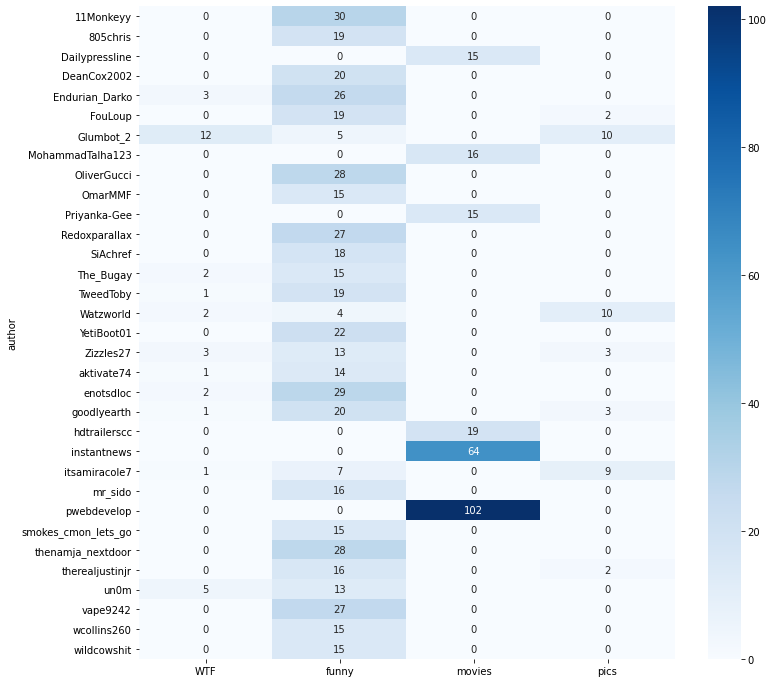

In [ ]:
def plot_author_heatmap(dataDf, activeAuthors):
    authSubDf = dataDf[dataDf['author'].isin(activeAuthors)][['author', 'subreddit']]  # Select posts made by the active authors
    oneHots = pd.get_dummies(authSubDf['subreddit'])  # One hot encode subreddit labels
    combinedDf = authSubDf.drop('subreddit', axis=1).join(oneHots)
    authorSubredditDf = combinedDf.groupby('author').sum()  # Group by author
    
    # Plot heatmap
    plt.figure(figsize=(12,12))
    sns.heatmap(authorSubredditDf, annot=True, cmap='Blues', fmt='g')
    
    return None

plot_author_heatmap(data, activeAuthors) 

The heatmap above shows the correlation between the author and subreddit for authors that made at least 15 posts.  We can see most authors tend to favour posting in a particular subreddit.  For example, **the most productive author "pwebdevelop" has a strong preference for r/movies and contributed all 102 posts to that subreddit.**  Therefore for posts made by active authors, the author is likely to be informative for subreddit classification and will be used as a feature.

**Column: created_utc**

The created_utc is the date and time in unix time stamp format so it needs to be converted to a datetime object to be analyzed.  

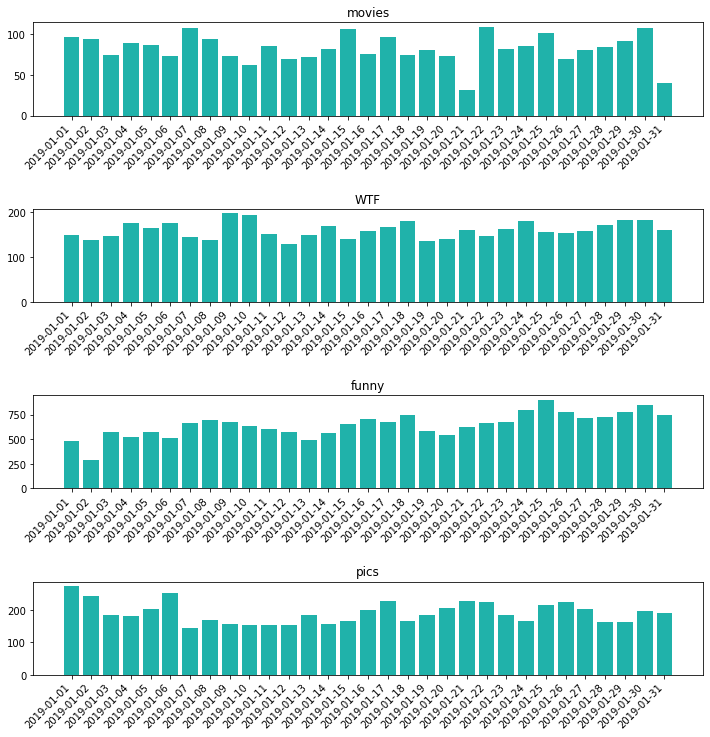

In [ ]:
def plot_time_histogram(dataDf):
    pd.plotting.register_matplotlib_converters()
    df = dataDf.copy()
    df['date'] = pd.to_datetime(df['created_utc'], unit='s').dt.date  # Convert utc to pandas date
    
    groupedDf = pd.pivot_table(df, values='created_utc', index='date', columns='subreddit', aggfunc='count')
    
    fig, axes = plt.subplots(4, 1, figsize=(12,12))
    plt.subplots_adjust(hspace=1)
    
    for i, sr in enumerate(my_subreddits):
        x = list(groupedDf.index)
        y = groupedDf[sr].values
        axes[i].bar(x, y, color=colour1)
        axes[i].set(title=sr)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(x, rotation=45, ha='right')
    
    return None

plot_time_histogram(data)

The bar plots above show the daily number of posts for each subreddit.  The proportion of posts from different subreddits varies across the days.  In the new year, there is an increase in posts from r/pics and decrease of posts in r/funny. r/movies has a significant dip in posts on Jan 21 and Jan 31.  r/WTF remains relatively constant across the days.  Therefore the post date could be informative for predicting the subreddit label.  It will be used as a feature after conversion to a date.

**Column: title**

We must clean the post titles before we can analyze it.  The titles will tokenized using RegexpTokenizer(r'\w+'), lemmatized, words less than 3 characters discarded, and converted to lower case.  This will allow us to reduce the vocabulary size by combining variation of words to a single word.  **At this point, we don't know if symbols such as "$" or "*" are useful for classification, therefore, they are appended to the string as pseudowords.** 

In [ ]:
def clean_text_columns(dataDf):
    """
    Returns dataframe of cleaned title and selftext columns only.
    """
    tokenizer = RegexpTokenizer(r'\w+')  # Word tokenizer
    wnLemm = WordNetLemmatizer()  # Lemmatizer
    myStopwords = stopwords.words('english')  # Stopwords
    
    def clean_text(text):
        # Remove missing entries (selftext only)
        if text in ['[removed]', '[deleted]']:
            return ""
        
        cleanedText = tokenizer.tokenize(text.lower())  # Tokenize and convert to lower case
        # Remove stop words / remove <3 letter words / lemmatize
        cleanedText = [wnLemm.lemmatize(word) for word in cleanedText if word not in myStopwords and len(word) > 2]  
        cleanedText = " ".join(cleanedText)
        
        # Add symbols as pseudowords
        for sym in '!@#$%^&*':
            if sym in text:
                numSym = text.count(sym)
                spacedSym = ' ' + sym
                cleanedText = cleanedText +  spacedSym * numSym
                
        return cleanedText    

    textDf = dataDf.copy()
    textDf['title_cleaned'] = textDf['title'].apply(clean_text)
    textDf['selftext_cleaned'] = textDf['selftext'].apply(clean_text)
    
    # Check if function for EDA dataframe or modelling df
    if 'subreddit' in list(dataDf.columns):  
        textDf = textDf.loc[:, ['subreddit', 'title_cleaned', 'selftext_cleaned']]
    else:
        textDf = textDf.loc[:, ['title_cleaned', 'selftext_cleaned']]

    return textDf

dataText = clean_text_columns(data)

In [ ]:
def text_MI(dataDf, column, k, y=None):
    """
    Computes dataframe of words ranked by mutual information between 
    words and subreddit class for k most frequent words amongst all subreddits.
    """
    dataDf = dataDf.copy()
    
    # Check if function for EDA dataframe or modelling df
    if ('subreddit' in list(dataDf.columns)) == False:
        dataDf['subreddit'] = y.values
    
    # All words, remove empty strings
    allWords = [word for word in np.hstack(dataDf[column].str.split().values) if word != ""] 
    topk = Counter(allWords).most_common(k)  # Counter for top k frequent words
    topkWords = [word for word, freq in topk]  # List of top k words
    
    # Dataframe containing posts with top k words
    topkDf = dataDf[dataDf[column].str.split(expand=True).isin(topkWords).any(axis=1)]  
    n = len(allWords)  # Total number of words
    numPosts = topkDf.shape[0]
    
    wordSr = {}  # Nested dictionary of word counts for each subreddit
    srTotals = {}  # Dictionary of total words for each subreddit
    srProb = {}  # py for each subreddit
    miData = []  # Dictionary to store mi data
    
    for sr in my_subreddits:
        srDf = topkDf[topkDf['subreddit'] == sr]  # Only posts in subreddit
        
        numInSr = srDf.shape[0]  # Number of post in subreddit
        srProb[sr] = numInSr / numPosts  # py

        srWords = np.hstack(srDf[column].str.split().values)  # All words in subreddit
        
        srTotals[sr] = len(srWords)  # Number of words in subreddit
        wordSr[sr] = dict(Counter(srWords).most_common())  # Dict of word counts in subreddit

        
    for word, freq in topk:
        wordMI = 0
        for sr in my_subreddits:
            try:
                pxy = wordSr[sr][word] / srTotals[sr]  # p(x|y)
            except:  # word does not exist in subreddit
                pxy = 0
            
            px = freq / n
            
            if pxy == 0:  # Prevent log(0)
                pmi = 0
            else:
                pmi = np.log2(pxy / px)  # pmi
                
            py = srProb[sr]
                
            wordMI += pxy * py * pmi  # p(x,y) x pmi (summation over all y)
            
        miData.append(wordMI)
    
    miDf = pd.DataFrame({'MI': miData}, index=topkWords).sort_values(by='MI', ascending=False)
    
    return miDf

titleWordMi = text_MI(dataText, column='title_cleaned', k=1000)
titleWordMi.head(25)

,MI
!,0.008589
movie,0.007369
wtf,0.003648
film,0.002864
like,0.001998
trailer,0.001760
nsfw,0.001496
true,0.001475
funny,0.001429
get,0.001363


The dataframe above shows the top 25 words sorted by mutual information (MI).  Not all words are equally informative and this allows us to identify which words are informative towards predicting the subreddit class. **We can see that symbols are infact relatively informative, therefore, they will be kept as features.**  However, MI alone doesn't tell us which subreddits the words are informative for.  For that, we will need to compute the pointwise mutual information (PMI).

In [ ]:
def text_pmi(dataDf, column, k):
    """
    Returns a dataframe of words ranked by pmi between words and specific subreddit class for 
    top k frequent words amongst all subreddits.
    """
    
    # All words, remove empty strings
    allWords = [word for word in np.hstack(dataDf[column].str.split().values) if word != ""]  
    topk = Counter(allWords).most_common(k)  # Counter for top k frequent words
    topkWords = [word for word, freq in topk]  # List of top k words
    
    # Dataframe containing posts with top k words
    topkDf = dataDf[dataDf[column].str.split(expand=True).isin(topkWords).any(axis=1)]  
    n = len(allWords)  # Total number of words
    
    wordSr = {}  # Nested dictionary of word counts for each subreddit
    srTotals = {}  # Dictionary of total words for each subreddit
    pmidata = {}  # Dictionary to store pmi data
    
    for sr in my_subreddits:
        srDf = topkDf[topkDf['subreddit'] == sr]

        srWords = np.hstack(srDf[column].str.split().values)  # All words in subreddit
        
        srTotals[sr] = len(srWords)  # Number of words in subreddit
        wordSr[sr] = dict(Counter(srWords).most_common())  # Dict of word counts in subreddit
        pmidata[sr] = []
        
    for word, freq in topk:
        
        for sr in my_subreddits:
            try:
                pxy = wordSr[sr][word] / srTotals[sr]  # p(x|y)
            except:  # site does not exist in subreddit
                pxy = 0
            
            px = freq / n
            
            if pxy == 0:  # Prevent log(0)
                pmi = np.nan
            else:
                pmi = np.log2(pxy / px)
                
            pmidata[sr].append(pmi)
    
    pmiDf = pd.DataFrame(pmidata, index=topkWords)
    
    sortedData = {}
    
    # Create a dataframe for results
    for sr in my_subreddits:
        sortedPmi = pmiDf.sort_values(by=sr, ascending=False)[sr].values  # Sort by pmi 
        sortedWords = pmiDf.sort_values(by=sr, ascending=False)[sr].index  # Index (word) from sorted pmi
        sortedCombined = [s + ' (' + str(round(p,2)) + ')' for p, s in zip(sortedPmi, sortedWords)]  # Combine
        sortedData[sr] = sortedCombined
    
    sortedPmiDf = pd.DataFrame(sortedData)
    
    return sortedPmiDf
    
text_pmi(dataText, column='title_cleaned', k=500).head(25)

,movies,WTF,funny,pics
0,oscar (3.05),wtf (2.57),oof (1.18),sunset (2.04)
1,trailer (3.02),nsfw (2.33),truth (1.16),painted (2.02)
2,film (2.99),foot (1.76),lol (1.09),painting (1.8)
3,movie (2.93),body (1.65),sometimes (1.09),mountain (1.72)
4,actor (2.87),police (1.57),true (1.09),taken (1.71)
5,official (2.87),woman (1.57),accurate (1.08),photo (1.65)
6,aquaman (2.63),driver (1.48),funny (1.08),took (1.62)
7,scene (2.53),dead (1.47),fact (0.99),lake (1.62)
8,netflix (2.5),kill (1.46),joke (0.98),view (1.62)
9,review (2.46),hair (1.44),sad (0.98),drew (1.61)


The dataframe above shows the top 25 ranked words by PMI for their respective class and the PMI value in brackets.  We can see words that intuitively belong to their class.  For example in r/movies, the informative words include "oscar", "teaser", "trailer" and in r/pics the words are "sunset", "painted", "portrait".  The words with high PMI between classes are different, therefore, the title words are informative for predicting the subreddit class and will be used as features.  Note that the PMI scores are typically higher in r/movies, meaning the title words are a strong predictor for r/movies.

**Column: num_comments**

,median,variance
subreddit,,
WTF,2.0,22269.999879
funny,11.0,39289.925290
movies,0.0,66724.141389
pics,5.0,77936.854848


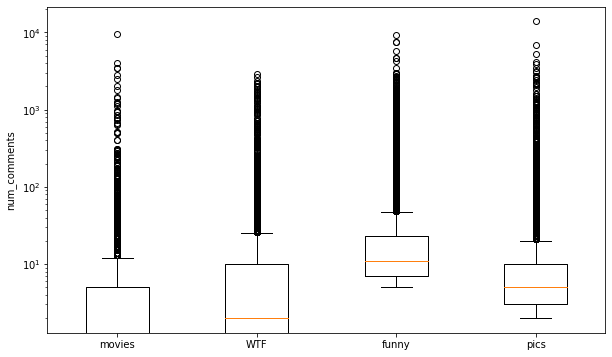

In [ ]:
def plot_boxplot(dataDf, column):
    plt.figure(figsize=(10,6))
    
    data = []
    
    for i, sr in enumerate(my_subreddits):
        data.append(dataDf[(dataDf['subreddit'] == sr)][column].values)
    
    plt.boxplot(data)
    plt.yscale('log')
    plt.ylabel(column)
    plt.xticks(np.arange(1, len(my_subreddits) + 1), my_subreddits)
    
    summaryDf = pd.concat([dataDf.groupby('subreddit').median()[column], dataDf.groupby('subreddit').var()[column]], axis=1)
    summaryDf.columns = ['median', 'variance']
    return summaryDf
        
num_comments_stats = plot_boxplot(data, 'num_comments')
num_comments_stats

The above boxplots show the distribution of the number of comments for each subreddit.  The distributions are extremely long tailed with the majority of posts containing less than 10 comments while several viral posts reach the range of 1000 to 10000 comments.  This behaviour is likely because reddit allows any author to post but only the best posts reach the front page which are then viewed by millions of users.  The IQR boxes are overlapping which suggests there isn't a significant difference in the number of comments however the median line of r/funny is above all the third quartiles suggesting there is some difference.  Therefore, the number of comments are likely to be informative for distinguishing between r/funny and other subreddits and will be used as a feature.

**Column: score**

,median,variance
subreddit,,
WTF,1.0,1.176410e+07
funny,50.0,6.988038e+07
movies,1.0,7.427445e+06
pics,14.0,7.005198e+07


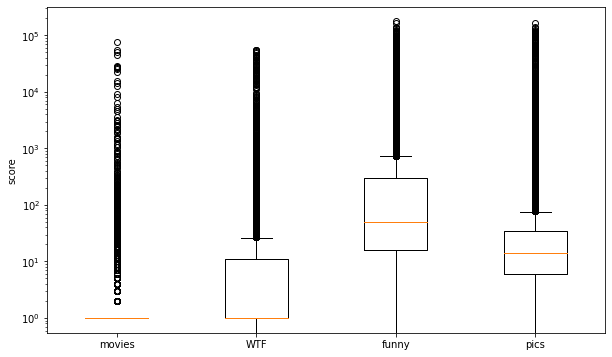

In [ ]:
score_stats = plot_boxplot(data, 'score')
score_stats

The above boxplots show the distribution of the score for each subreddit.  Similar to the num_comments, the distributions are long tailed, especially for r/movies.  r/funny can be distinguished from the other subreddits because it's Q1 is above the Q3 of r/movies and r/WTF, and also its median is above Q3 of r/pics.  r/pics can also be likely distinguished from r/WTF and r/movies since the median is above their third quantiles.  Therefore, the score is likely informative for distinguishing r/funny and r/pics from the other two subreddits.

**Column: selftext**

In the selftext column, missing entries are represented by "[deleted]" as well as "[removed]".  There are also entries that contain empty selftext represented by an empty string.  There are only 1022 posts that have selftext, which occur only in r/moves and r/funny, with the majority in the former.  NLP would not be very beneficial since the data is so sparse, however, it could be a good indicator if a post is in these two subreddits if it contains a non-empty selftext.

In [ ]:
data[(data['selftext'].str.len() > 0) & ~(data['selftext'].isin(['[deleted]', 'removed']))].groupby('subreddit').count().rename(columns={'selftext': 'Num. containing selftext'})['Num. containing selftext']

subreddit
funny     157
movies    865
Name: Num. containing selftext, dtype: int64

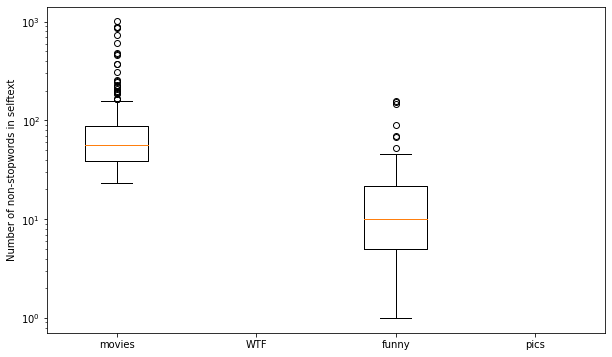

In [ ]:
def plot_boxplot_selftext(dataDf, column='selftext_cleaned'):
    plt.figure(figsize=(10,6))
    
    data = []
    
    for i, sr in enumerate(my_subreddits):
        text = dataDf[(dataDf['subreddit'] == sr)][column].tolist()
        length = [len(t.split()) for t in text if t != ""]
                 
        data.append(length)
    
    plt.boxplot(data)
    plt.yscale('log')
    plt.ylabel('Number of non-stopwords in selftext')
    plt.xticks(np.arange(1, len(my_subreddits) + 1), my_subreddits)

    return None
        
selftext_stats = plot_boxplot_selftext(dataText)
selftext_stats

Above are boxplots for the number of non-stopwords in selftext.  We can see that the Q3 of r/funny is below the minimum of r/movies which shows significant difference.  Therefore, for the few posts containing selftext, we are likely to distinguish between r/movies and r/funny by using the word count of the selftext as features.

**Column: url**

To analyze if the url is informative for the subreddit, we will check to see if subreddits contain more links to certain websites than others.

Some posts provide a url to another reddit post and **usually** the other post is in the same subreddit.  An example is shown below.  The majority of such urls are from r/movies.  This could be a heuristic for classifying the post directly.

In [ ]:
data.loc[[154899], :][['subreddit', 'title', 'url']]

,subreddit,title,url
154899,movies,"""John Wick 3"" is ""I Am a legend"" prequel",https://www.reddit.com/r/movies/comments/ainr8...


The dataframe below shows that the subreddit usually links to its own subreddit. Axis 0 is the post subreddit and axis 1 is the linked subreddit.  We can see that greatest numbers are in the diagonal.

In [ ]:
srURLCount = {}

for sr in my_subreddits:
    srURLCount[sr] = [0] * len(my_subreddits)
    #groupbySR = data[data['url'].str.contains(sr)].groupby('subreddit').count()['url']
    for i, s in enumerate(my_subreddits):
        try:
            srURLCount[sr][i] = data[data['url'].str.contains(sr)].groupby('subreddit').count()['url'].loc[s]
        except:
            srURLCount[sr][i] = 0
        
pd.DataFrame(srURLCount, index=[i + ' linked in url' for i in my_subreddits]).transpose()

,movies linked in url,WTF linked in url,funny linked in url,pics linked in url
movies,1008,0,0,0
WTF,0,5,1,0
funny,3,5,189,1
pics,3,4,1,22


The subreddits r/WTF, r/funny, and r/movies also contain youtube links for their post's video.  r/pics doesn't have any youtube links because the subreddit is reserved for pictures only.  A youtube link can have the form youtube.com, a shortened youtu.be, or the mobile version m.youtube.com.  Since they are all youtube video links, they can be collapsed into one category.  Examples are shown below.  The same procedure is done for imgur.com.

In [ ]:
# Counts of youtube links
data[data['url'].str.contains("youtube|youtu.be")].groupby('subreddit').count()['url']

subreddit
WTF       623
funny     218
movies    447
Name: url, dtype: int64

In [ ]:
# Example of youtube links
data.loc[[171601, 210338, 119639], :][['subreddit', 'title', 'url']]

,subreddit,title,url
171601,movies,"Out of Blue - Starring Patricia Clarkson, Toby...",https://www.youtube.com/watch?v=JsNBLkO2Itg
210338,movies,A Dog's Journey Trailer #1 (2019) | [Best Movi...,https://youtu.be/8frHkzcK28o
119639,movies,John Wick 3 Official FULL Trailer,https://m.youtube.com/watch?v=NbUt7Apl_Z0


The below function processess the url by extracting the website with exceptions for the cases mentioned previously.

In [ ]:
def get_website(url):
    """
    Extract website name from url.
    """
    for subreddit in my_subreddits:
        if 'r/' + subreddit in url:
            return 'reddit.com/r/' + subreddit

    # Check for youtube in url
    if any(yt in url for yt in ['youtube.com', 'youtu.be']):
        return 'youtube.com'
    elif any(im in url for im in ['m.imgur.com', 'imgur.com']):
        return 'imgur.com'

    # Return website name otherwise
    if 'www.' in url:
        siteName = url.split('www.')[1]
    else:
        siteName = url.split('://')[1]

    siteName = siteName.split('/')[0]

    return siteName


def process_url(dataDf):
    """
    Returns dataframe with addition column "website" which is the website extracted from the url.
    """
    data_url_processed = dataDf.copy()
    data_url_processed['website'] = dataDf['url'].apply(get_website)
    
    return data_url_processed

data_url_processed = process_url(data)
data_url_processed[['subreddit', 'title', 'url', 'website']].head()

,subreddit,title,url,website
1,pics,"In 1964, an average wage worker had to clock 8...",https://i.redd.it/j6rqqthwcp721.jpg,i.redd.it
5,pics,Here’s a reminder to grab one of these for a b...,https://i.redd.it/063lwxm0dp721.jpg,i.redd.it
13,pics,My best photo of 2018!,https://i.redd.it/nkcs1p8adp721.jpg,i.redd.it
14,pics,Have a happy 2019 you sexy people!,https://i.redd.it/kphnhymddp721.jpg,i.redd.it
15,movies,I’ve seen several movies/shows over the past f...,https://www.reddit.com/r/movies/comments/abcvw...,reddit.com/r/movies


Below we show the top 10 linked websites which accounts for over 95% of all websites.  The most frequent site is i.redd.it which is the reddit server that hosts images and it accounts for approximately 65% of all websites.  The second most frequent is v.redd.it which is the reddit server that hosts videos.  We also see other media hosting platforms such as imgur, youtube, and gyfcat.  We also see the linked subreddits (r/movies and r/funny) described previously.

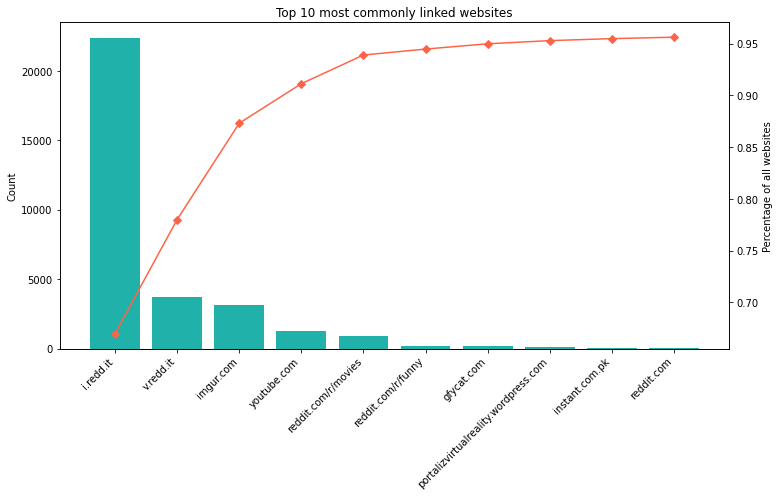

In [ ]:
def plot_websites(urlDf):
    counter = Counter(urlDf['website'].values).most_common()
    y = [count for site, count in counter]
    cumPercentage = np.cumsum(y) / np.sum(y)
    sites = [site for site, count in counter]
    x = np.arange(len(sites))[0:10]
    
    fig, ax1 = plt.subplots(figsize=(12,6))

    ax1.bar(x, y[0:10], color=colour1)
    ax1.set_title('Top 10 most commonly linked websites')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels=sites[0:10], rotation=45, ha='right')
    ax1.set_ylabel('Count')
    
    ax2 = ax1.twinx()
    ax2.plot(x, cumPercentage[0:10], marker='D', color=colour2)
    ax2.set_ylabel('Percentage of all websites')

    return None 

plot_websites(data_url_processed)

To determine which website is informative about the subreddit, we take a look at the pointwise mutual information for each website and subreddit pair for the top 10 websites.  The PMIs are computed and the websites are ranked by PMI shown in the below function.

In [ ]:
def site_pmi(dataDf, column, k):
    """
    Returns a dataframe of websites ranked by pmi between websites and specific subreddit class for 
    top k frequent websites amongst all subreddits.
    """
    topk = Counter(dataDf[column].values).most_common(k)  # Dict for top k frequent sites
    topkSites = [site for site, freq in topk]  # List of top k sites
    
    topkDf = dataDf[dataDf[column].isin(topkSites)]  # Dataframe containing posts with top k websites
    n = topkDf.shape[0]  # Total posts
    
    sitesSr = {}  # Nested dictionary of site counts for each subreddit
    srTotals = {}  # Dictionary of total sites for each subreddit
    pmidata = {}  # Dictionary to store pmi data
    
    for sr in my_subreddits:
        srDf = topkDf[topkDf['subreddit'] == sr]
        srTotals[sr] = srDf.shape[0]  # Total sites in subreddit
        sitesSr[sr] = dict(Counter(srDf[column].values).most_common())  # Dict of site counts in subreddit
        pmidata[sr] = []
        
    for site, freq in topk:
        for sr in my_subreddits:
            try:
                pxy = sitesSr[sr][site] / srTotals[sr]  # p(x|y)
            except:  # site does not exist in subreddit
                pxy = 0
            
            px = freq / n
            
            if pxy == 0:  # Prevent log(0)
                pmi = np.nan
            else:
                pmi = np.log2(pxy / px)
                
            pmidata[sr].append(pmi)
    
    pmiDf = pd.DataFrame(pmidata, index=topkSites)
    
    sortedData = {}
    
    for sr in my_subreddits:
        sortedPmi = pmiDf.sort_values(by=sr, ascending=False)[sr].values  # Sort by pmi 
        sortedSites = pmiDf.sort_values(by=sr, ascending=False)[sr].index  # Index (site) from sorted pmi
        sortedCombined = [s + ' (' + str(round(p,2)) + ')' for p, s in zip(sortedPmi, sortedSites)]  # Combine
        sortedData[sr] = sortedCombined
    
    sortedPmiDf = pd.DataFrame(sortedData)
    
    return sortedPmiDf
    
site_pmi(data_url_processed, column='website', k=10)   

,movies,WTF,funny,pics
0,reddit.com/r/movies (4.14),reddit.com (2.37),reddit.com/r/funny (0.63),imgur.com (0.49)
1,portalizvirtualreality.wordpress.com (4.14),youtube.com (1.84),v.redd.it (0.25),i.redd.it (0.3)
2,instant.com.pk (4.14),gfycat.com (1.7),i.redd.it (0.1),reddit.com/r/funny (-5.14)
3,youtube.com (2.59),v.redd.it (0.88),imgur.com (-0.17),v.redd.it (nan)
4,reddit.com (2.29),imgur.com (0.4),gfycat.com (-0.17),youtube.com (nan)
5,i.redd.it (-2.51),i.redd.it (-0.52),youtube.com (-1.87),reddit.com/r/movies (nan)
6,imgur.com (-2.76),reddit.com/r/funny (-2.71),reddit.com (-4.87),gfycat.com (nan)
7,gfycat.com (-3.27),reddit.com/r/movies (nan),reddit.com/r/movies (nan),portalizvirtualreality.wordpress.com (nan)
8,v.redd.it (-3.38),portalizvirtualreality.wordpress.com (nan),portalizvirtualreality.wordpress.com (nan),instant.com.pk (nan)
9,reddit.com/r/funny (-3.44),instant.com.pk (nan),instant.com.pk (nan),reddit.com (nan)


The dataframe above shows the websites ranked by PMI. We can see the subreddit links have high PMI with their respective subreddits which is expected.  

From this data, we can also draw insights not obvious before.  Some examples are:
- portalizvirtualreality.wordpress.com and instant.com.pk is exclusively in r/movies
- gyfcat.com is only positively associated with only r/WTF
- imgur.com is highly associative with r/WTF and r/pics
- The most common site, i.redd.it is only postively associated with r/funny and r/pics

Therefore, extracting websites from the urls can be highly informative for predicting the subreddit class but only around 10 webistes are informative.

**Correlation between columns**

Sometimes columns are correlated and can allow us to remove redundant columns.  The columns num_comments and score may be correlated since we can hypothesize that a popular post would have more comments as well as more upvotes.  Therefore we will analyze this pair of columns. The scatter plot below allows us to visualize the correlation between the two columns.  **The columns are positively correlated with a Pearson correlation coefficient of 0.75.**  Since the correlation is not very strong, and numerous outliers are seen, we will not treat these columns as redundant and use them both as features.

Pearson correlation coefficient = 0.75


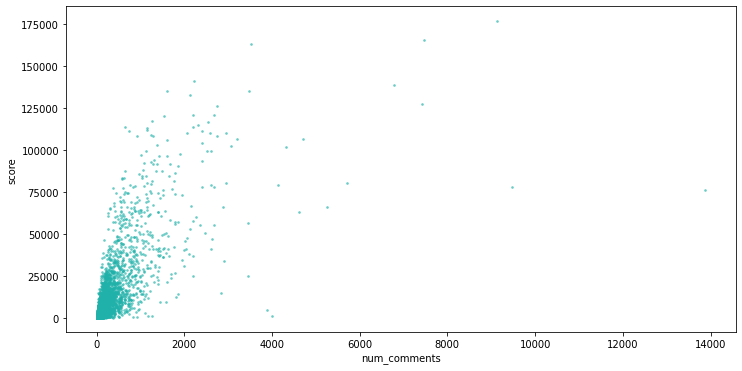

In [ ]:
def plot_scatter(dataDf):
    x = dataDf['num_comments'].values
    y = dataDf['score'].values
    
    plt.figure(figsize=(12,6))
    plt.xlabel('num_comments')
    plt.ylabel('score')
    plt.scatter(x, y, s=3, c=colour1, alpha=0.5)
    
    print("Pearson correlation coefficient = {}".format(round(np.corrcoef(x,y)[0,1], 2)))
                                             
    return None

plot_scatter(data)

### (c)

Finally, we will check if the dataset is balanced or imbalanced.  The pie chart below shows the distribution of the subreddit labels.  **We can see that the dataset is highly imblanced**, with 60% of posts in r/funny and only 8% in r/movies.  This will help us decide which metric to use when evaluating our models.

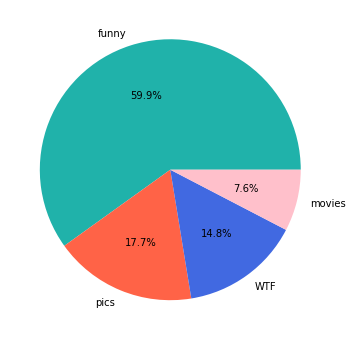

In [ ]:
def label_distribution(dataDf):
    counter = Counter(data['subreddit'].values).most_common()
    subreddits = [sr for sr, freq in counter]
    counts = [freq for ser, freq in counter]
    
    plt.figure(figsize=(12,6))
    plt.pie(counts, labels=subreddits, autopct='%1.1f%%', colors=[colour1, colour2, colour3, colour4])
    
    return None

label_distribution(data)

## Part 3: Classification

We will split the dataset into 70% train, 15% validation, and 15% test.  The train set will be used to train different machine learning algorithms and the validation set will be used to measure the performance to allow us to select one algorithm.  **Since the validation set is small, we need to use cross validation to have confidence in the performance metric when tuning hyperparameters.  The combined train and validation set will be used for cross validation (X_cv) to tune the hyperparameters of the selected model.** The test set will be used to evaluate the model performance at the very end.

In [ ]:
X = data.drop(columns=['id', 'subreddit'])
y = data['subreddit'].copy()

# 70% train, 15% val, 15% test
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.15, random_state=1513)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.176, random_state=1513)

### Feature Engineering

Before we implement machine learning models, we need to transform the dataset columns into features.  

**author**<br>
We determined that authors with at least 15 posts frequently post in the same subreddit.  To use this information as a feature, we will create one hot encoded features for those authors only.  The list of authors will be determined based on the training set only to prevent data leakage from the test set.  This is performed in the "preprocess_authors" function.

**created_utc**<br>
We determined that the likelihood of posts in subreddits is correlated with the post date.  To use this information as a feature, we will convert the timestamp to an ordinal date (day 1 to 365).  The year is unimportant since posts are only from January 2019.  The data is not one hot encoded since the order of the date is relevant.  This is performed in the "preprocess_utc" function.

**title**<br>
From the pmi analysis, we determied that the words in the title are informative to the subreddit class.  The titles will be cleaned and since we also saw that symbols are informative, they will also be included. To transform the cleaned titles to features, both word frequency and TF-IDF tokenizing methods will be tested.  There will be too many features if all the words in the vocabulary are used.  We can choose to limit the number of words in the WF and TF-IDF tokenizers, but it will select the words with highest term frequency.  This is undesired, because it may select words that are frequent, but not necessarily informative.  We saw in the MI analysis that not all words are equally informative, so the way we will select the subset of words is to use the top k words ranked by MI.  These top words will determined from the train set only to prevent test data leakage.  There isn't a standard method to select the k that I'm aware of so we will test different k values.  The title cleaning is performed by the "preprocess_title" function.

**num_comments and score**<br>
From the boxplots, we determined that these numerical features are informative.  We will scale these features (explained in next section).

**selftext**<br>
We saw that the number of posts with selftext is extremely sparse and that only posts in r/movies and r/funny have any selftext.  We also saw that there is a significant difference in the length of selftext between those two subreddits.  Therefore, we will use the number of non-stopwords in selftext as a feature.  This is done in the "preprocess_selftext" function.

**url**<br>
We determined from the PMI analysis that the websites in the url are informative.  However, more than 95% of websites are in the top 10 sites.  To allow these features to generalize well, only the top 10 websites will be used as features.  One hot encoded features of the top 10 websites will be used as features.  The top 10 will be determined from the train set only to prevent test data leakage.  The urls are processed in the "preprocess_url" function.


In [ ]:
# Preprocessing functions
def preprocess_authors(df, authors):
    """
    Returns dataframe of authors column with one hot encoded features of TOP authors.
    
    params:
    -------
    authors: List of top authors determined from train set
    """
    newDf = df.copy()

    for author in authors:
        newDf[author] = newDf['author'].apply(lambda a: 1 if a == author else 0)

    newDf = newDf.drop(columns=['author'])

    return newDf

def preprocess_utc(df):
    """
    Returns dataframe with created_utc column replaced by ordinal date (1 to 365).
    """
    newDf = df.copy()
    days = pd.to_datetime(newDf['created_utc'], unit='s').dt.dayofyear  # Ordinal day of year
    newDf['created_utc'] = days
    newDf = newDf.rename(columns={'created_utc':'utc_day'})

    return newDf

def preprocess_title(df):
    """
    Returns dataframe with cleaned title and selftext columns.
    """
    newDf = df.copy()
    textDf = clean_text_columns(df)
    
    newDf['title'] = textDf['title_cleaned']
    newDf['selftext'] = textDf['selftext_cleaned']
    
    return newDf

def preprocess_selftext(df):
    """
    Returns dataframe with selftext replaced by the number of words of cleaned selftext.
    """
    newDf = df.copy()
    newDf['selftext'] = newDf['selftext'].str.split().str.len()  # Word count
    newDf = newDf.rename(columns={'selftext': 'selftext_length'})
    
    return newDf

def preprocess_url(df, websites):
    """
    Returns dataframe of url column with one hot encoded features of TOP websites.
    """
    newDf = df.copy()
    newDf['url'] = newDf['url'].apply(get_website)
    
    for website in websites:
        newDf[website] = newDf['url'].apply(lambda w: 1 if w == website else 0)

    newDf = newDf.drop(columns=['url'])
    
    return newDf

### Data Preprocessing

As mentioned, to prevent test data leakage, we need to preprocess the train and test data separately.  The function "train_transform_pipeline" creates the features described above for the train set.  It also returns the word vectorizer using the top k MI word vocabulary, the top websites, and top authors.

We will not be using distance-based machine learning algorithms, however we will be using L2 regularization in logistic regression.  Therefore to ensure the features are penalized equally and to speed up gradient descent, the features must be scaled.  Since the features can't be negative for Naive Bayes, min-max scaling is used to scale all features between 0 and 1.  The scaler object will be fit and transformed to the train data in the "train_transform_pipeline" function and used to transform the test data.

The parameters numWords and vectMethod allows us to test different feature sets to tune the number of words used and the the vectorization method.

The function "test_transform_pipeline" takes in the word vectorizer, top websites, top authors, and scaler object fit to the train set and transforms the test set.  We will use it to transform the validation set now and use it to transform the test set at the very end.

In [ ]:
def train_transform_pipeline(X_train, y_train, numWords, vectMethod='tfidf'):
    
    def fit_title_wf(df, vocab):
        vectorizer = CountVectorizer(vocabulary=vocab)
        vectorizer.fit(df['title_cleaned'])
        
        return vectorizer
    
    def fit_title_tfidf(df, vocab):
        vectorizer = TfidfVectorizer(vocabulary=vocab)
        vectorizer.fit(df['title_cleaned'])

        return vectorizer
    
    X_train = X_train.rename(columns={'score':'post_score'})  # Prevent conflict with the word feature "score"
    authors = active_authors(X_train, k=15)  # Authors with minimum 15 posts
    # Top 10 websites
    websites = [site for site, freq in Counter(X_train['url'].apply(get_website).values).most_common(10)]  
    X_train_text = clean_text_columns(X_train)  # Dataframe of cleaned title and selftext
    
    # Vocab of top k words ranked by MI
    vocab = list(text_MI(X_train_text, column='title_cleaned', k=10000, y=y_train).index)[0:numWords]  
    
    # Fit the selected vectorizer
    if vectMethod == 'wf':
        vectorizer = fit_title_wf(X_train_text, vocab)
    elif vectMethod =='tfidf':
        vectorizer = fit_title_tfidf(X_train_text, vocab)

    # Preprocess all columns 
    X_t = preprocess_authors(X_train, authors)
    X_t = preprocess_utc(X_t)
    X_t = preprocess_title(X_t)
    X_t = preprocess_selftext(X_t)
    X_t = preprocess_url(X_t, websites)

    # Vectorize words, convert to dataframe, join with feature dataframe
    vectorizedTitle = vectorizer.transform(X_t['title']).todense()  
    vectorizedTitleDf = pd.DataFrame(vectorizedTitle, columns=vectorizer.get_feature_names(), index=X_t.index)
    X_t = X_t.drop(columns=['title']).join(vectorizedTitleDf)  
    
    # Fit the min-max scaler
    scaler = MinMaxScaler()
    scaler.fit(X_t)
    
    X_t = scaler.transform(X_t)  # Scale the data
    
    return X_t, (authors, websites, vectorizer, scaler)

def test_transform_pipeline(X, authors, websites, vectorizer, scaler, returnFeatures=False):
    X = X.rename(columns={'score': 'post_score'})  # Prevent conflict with the word feature "score"
    
    # Preprocess all columns 
    X_t = preprocess_authors(X, authors)
    X_t = preprocess_utc(X_t)
    X_t = preprocess_title(X_t)
    X_t = preprocess_selftext(X_t)
    X_t = preprocess_url(X_t, websites)
    
    # Vectorize words, convert to dataframe, join with feature dataframe
    vectorizedTitle = vectorizer.transform(X_t['title']).todense()  
    vectorizedTitleDf = pd.DataFrame(vectorizedTitle, columns=vectorizer.get_feature_names(), index=X_t.index)
    X_t = X_t.drop(columns=['title']).join(vectorizedTitleDf)
    featureNames = X_t.columns
    
    X_t = scaler.transform(X_t)  # Scale the data
    
    if returnFeatures == True:
        return X_t, featureNames
    
    else:
        return X_t


### Machine Learning Model Implementation

We will test four different feature sets by testing the two vectorization methods and varying the vocabulary size.  WF is the word frequency, which is simply using the word counts as a feature vector.  TF-IDF is the term frequency-inverse document frequency which also considers how rare the word is across all titles.

Set 1: vectorizer = TF-IDF, number of words = 1000<br>
Set 2: vectorizer = WF, number of words = 1000<br>
Set 3: vectorizer = TF-IDF, number of words = 2000<br>
Set 4: vectorizer = WF, number of words = 2000<br>

For each feature set, we will also test three classification algorithms.  The first is logistic regression using the one-vs-rest method which will fit a classifier for each subreddit class and return the one with the highest probability.  L2 regularization with lambda=1 will be used to control overfitting.  The second is Naive Bayes. The third is random forests with 100 forests.  Distance-based classifiers such as KNN and SVM were not tested since the compuation time is extraordinary given the large number of samples and features.

**Here are four potential metrics that can be used to measure the performance of the classifiers:**

1. Accuracy is the percentage of correct classifications.  It is a bad measure of performance if the dataset is imbalanced since it can achieve a high score by simply always predicting the majority class.  

2. Recall (sensitivity) is the percentage of positives detected out of all the positives in the data.  This is a useful metric if it is important in the classification to correctly detect positives out of many negatives.  For example, the recall is important for detecting patients with a disease out of many patients that did not have the disease.

3. Precision is the percentage of classified positives that are actually positives.  It's a measure of how good the classifier is at classifying samples correctly.  This is a useful metric if it is important that classified positives are actually positives.  For example, a spam filter needs to have high precision to not accidentally filter out good email as spam.

3. F1 score is the harmonic mean between precision and recall.  It is a good measure when both precision and important are important.

Since the dataset is imbalanced and the precision and recall is important for multiclass classification, F1 score will be the performance metric.  The macro F1 score is the unweighted average of the F1 scores for each class treated as a binary classification problem.  This makes it a robust metric since the score will be equally penalized even if the smallest class has poor recall or precision.  

In [ ]:
# Feature set 1
X_train1, pipelineArgs1 = train_transform_pipeline(X_train, y_train, numWords=1000, vectMethod='tfidf')
X_val1 = test_transform_pipeline(X_val, *pipelineArgs1)

lr_clf1 = LogisticRegression(random_state=1513, solver='sag', multi_class='ovr', penalty='l2', C=1).fit(X_train1, y_train)
lr_pred1 = lr_clf1.predict(X_val1)
lr_clf1_f1 = f1_score(y_val, lr_pred1, average='macro')

nb_clf1 = MultinomialNB().fit(X_train1, y_train)
nb_pred1 = nb_clf1.predict(X_val1)
nb_clf1_f1 = f1_score(y_val, nb_pred1, average='macro')

rf_clf1 = RandomForestClassifier(n_estimators=100, random_state=1513).fit(X_train1, y_train)
rf_pred1 = rf_clf1.predict(X_val1)
rf_clf1_f1 = f1_score(y_val, rf_pred1, average='macro')

In [ ]:
# Feature set 2
X_train2, pipelineArgs2 = train_transform_pipeline(X_train, y_train, numWords=1000, vectMethod='wf')
X_val2 = test_transform_pipeline(X_val, *pipelineArgs2)

lr_clf2 = LogisticRegression(random_state=1513, solver='sag', multi_class='ovr', penalty='l2', C=1).fit(X_train2, y_train)
lr_pred2 = lr_clf2.predict(X_val2)
lr_clf2_f1 = f1_score(y_val, lr_pred2, average='macro')

nb_clf2 = MultinomialNB().fit(X_train2, y_train)
nb_pred2 = nb_clf2.predict(X_val2)
nb_clf2_f1 = f1_score(y_val, nb_pred2, average='macro')

rf_clf2 = RandomForestClassifier(n_estimators=100, random_state=1513).fit(X_train2, y_train)
rf_pred2 = rf_clf2.predict(X_val2)
rf_clf2_f1 = f1_score(y_val, rf_pred2, average='macro')

In [ ]:
# Feature set 3
X_train3, pipelineArgs3 = train_transform_pipeline(X_train, y_train, numWords=2000, vectMethod='tfidf')
X_val3 = test_transform_pipeline(X_val, *pipelineArgs3)

lr_clf3 = LogisticRegression(random_state=1513, solver='sag', multi_class='ovr', penalty='l2', C=1).fit(X_train3, y_train)
lr_pred3 = lr_clf3.predict(X_val3)
lr_clf3_f1 = f1_score(y_val, lr_pred3, average='macro')

nb_clf3 = MultinomialNB().fit(X_train3, y_train)
nb_pred3 = nb_clf3.predict(X_val3)
nb_clf3_f1 = f1_score(y_val, nb_pred3, average='macro')

rf_clf3 = RandomForestClassifier(n_estimators=100, random_state=1513).fit(X_train3, y_train)
rf_pred3 = rf_clf3.predict(X_val3)
rf_clf3_f1 = f1_score(y_val, rf_pred3, average='macro')

In [ ]:
# Feature set 4
X_train4, pipelineArgs4 = train_transform_pipeline(X_train, y_train, numWords=2000, vectMethod='wf')
X_val4 = test_transform_pipeline(X_val, *pipelineArgs4)

lr_clf4 = LogisticRegression(random_state=1513, solver='sag', multi_class='ovr', penalty='l2', C=1).fit(X_train4, y_train)
lr_pred4 = lr_clf4.predict(X_val4)
lr_clf4_f1 = f1_score(y_val, lr_pred4, average='macro')

nb_clf4 = MultinomialNB().fit(X_train4, y_train)
nb_pred4 = nb_clf4.predict(X_val4)
nb_clf4_f1 = f1_score(y_val, nb_pred4, average='macro')

rf_clf4 = RandomForestClassifier(n_estimators=100, random_state=1513).fit(X_train4, y_train)
rf_pred4 = rf_clf4.predict(X_val4)
rf_clf4_f1 = f1_score(y_val, rf_pred4, average='macro')

The table below shows the macro F1 scores of the different feature sets and classifiers.  The best performing classifier is random forests followed by logistic regression and Naive Bayes.  The different feature set doesn't affect the performance significantly, but the "best" performing set is word frequency with a vocabulary of 2000 words.  We only tested it on one small validation set so this is not neccesarily the best classifier.  However, this is a quick heuristic method to choose a classifier for further hyperparamter tuning.

In [ ]:
results1 = pd.DataFrame({'Logistic Regression': [lr_clf1_f1, lr_clf2_f1, lr_clf3_f1, lr_clf4_f1], 
                         'Naive Bayes': [nb_clf1_f1, nb_clf2_f1, nb_clf3_f1, nb_clf4_f1], 
                         'Random Forests': [rf_clf1_f1, rf_clf2_f1, rf_clf3_f1, rf_clf4_f1]}, 
                        index=['[TFIDF, numWords=1000] F1', 
                               '[WF, numWords=1000] F1', 
                               '[TFIDF, numWords=2000] F1', 
                               '[WF, numWords=2000] F1'])
results1.index.name = 'Feature set'
results1

,Logistic Regression,Naive Bayes,Random Forests
Feature set,,,
"[TFIDF, numWords=1000] F1",0.637734,0.612862,0.749756
"[WF, numWords=1000] F1",0.639522,0.603995,0.755310
"[TFIDF, numWords=2000] F1",0.644071,0.620036,0.753729
"[WF, numWords=2000] F1",0.644978,0.617720,0.761546


Since the classifier perforance greatly depends on the hyperparemeters, we will need to tune the hyperparmeters to see which classifier truely performs the best.  Naive Bayes doesn't have any hyperparemeters that are significiant to tune other than the number of features, therefore only random forests and logistic regression will be tuned.  The feature set will be constructed using the "best" parameters of the word frequency vectorizer and 2000 words.

### Hyperparameter Tuning

As mentioned before, the hyperparemter will be tuned using 70% of the dataset and 5-fold cross validation will be used to measure the performance.  This means the training set will be split into five parts and each time four parts will be used for training while the fifth part will be used for validation.  Each of the five parts takes turn to be the validation part.  Therefore five classifiers will be fit and tested for each hyperparameter. This provides us more confidence in the performance if it performs well across all the folds.  The performance measure will also be the macro F1 score.

To manage computation time, only the most important hyperparamter will be tuned.  For logistic regression, the regularization parameter C will be tuned with values (10000, 1000, 100, 1, 0.1).  For random forests, the maximum tree depth will be tuned with values (20,50,100,200,500).

In [ ]:
# Tranform new cross validation set with 70% data
X_cv5, pipelineArgs5 = train_transform_pipeline(X_cv, y_cv, numWords=2000, vectMethod='wf')

In [ ]:
# Cross validation hyperparameter tuning for logistic regression
lr_parameters = {'C':(10000,1000,100,1,0.1)}

lr_clf_cv =  LogisticRegression(random_state=1513, solver='sag', multi_class='ovr', penalty='l2')
lr_gs_clf = GridSearchCV(lr_clf_cv, 
                      lr_parameters, 
                      cv=5, 
                      scoring='f1_macro', 
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
# Since hyperparameter tuning takes over 40 minutes, I have saved the results.
#lr_gs_clf.fit(X_cv5, y_cv)  

In [ ]:
#lr_cvDf = pd.DataFrame(lr_gs_clf.cv_results_)
lr_cvDf = pd.DataFrame(
  {'mean_fit_time': {0: 174.17331457138062,
  1: 162.81139426231385,
  2: 158.64214429855346,
  3: 39.58912653923035,
  4: 27.211427927017212},
 'std_fit_time': {0: 4.877682663218433,
  1: 0.7360844980239539,
  2: 2.503452955804535,
  3: 0.5368842917877413,
  4: 0.31648352002780766},
 'mean_score_time': {0: 0.10053133964538574,
  1: 0.0614356517791748,
  2: 0.062233591079711915,
  3: 0.06562457084655762,
  4: 0.05425496101379394},
 'std_score_time': {0: 0.03141479369195739,
  1: 0.0042596113460869325,
  2: 0.006543251553193377,
  3: 0.010914350534656106,
  4: 0.002998616359948027},
 'param_C': {0: 10000, 1: 1000, 2: 100, 3: 1, 4: 0.1},
 'params': {0: {'C': 10000},
  1: {'C': 1000},
  2: {'C': 100},
  3: {'C': 1},
  4: {'C': 0.1}},
 'split0_test_score': {0: 0.6787957973267611,
  1: 0.6792524204673396,
  2: 0.6779421006897887,
  3: 0.6649097870948263,
  4: 0.5774350881747039},
 'split1_test_score': {0: 0.6973239002509963,
  1: 0.6973239002509963,
  2: 0.6976558557726571,
  3: 0.6830047766112746,
  4: 0.5877216115263275},
 'split2_test_score': {0: 0.6714047275671554,
  1: 0.6718942002670373,
  2: 0.6734393647033902,
  3: 0.6542295784488578,
  4: 0.5797788729765834},
 'split3_test_score': {0: 0.6742371833253551,
  1: 0.6741107334920552,
  2: 0.6742046182725409,
  3: 0.6431470854293361,
  4: 0.5709289749624893},
 'split4_test_score': {0: 0.6787072268797306,
  1: 0.6788337901694566,
  2: 0.679749130974505,
  3: 0.6607644155474419,
  4: 0.5745660618907046},
 'mean_test_score': {0: 0.6800937670699997,
  1: 0.680283008929377,
  2: 0.6805982140825764,
  3: 0.6612111286263472,
  4: 0.5780861219061617},
 'std_test_score': {0: 0.009058517419848564,
  1: 0.008966865890320242,
  2: 0.008841563349577008,
  3: 0.013144538173983386,
  4: 0.005652388631578194},
 'rank_test_score': {0: 3, 1: 2, 2: 1, 3: 4, 4: 5},
 'split0_train_score': {0: 0.756037503906531,
  1: 0.7558554209205041,
  2: 0.75525127586411,
  3: 0.7023951653092886,
  4: 0.5948116280435178},
 'split1_train_score': {0: 0.7539612081597287,
  1: 0.7541081590488585,
  2: 0.753262529643884,
  3: 0.6982418235169345,
  4: 0.5874651250041031},
 'split2_train_score': {0: 0.7548208907777418,
  1: 0.7548671341944797,
  2: 0.7543819102736765,
  3: 0.7046570368493223,
  4: 0.5923340421064693},
 'split3_train_score': {0: 0.7578226010017258,
  1: 0.75771405767421,
  2: 0.7571150860575617,
  3: 0.7077146941315849,
  4: 0.5946624245478289},
 'split4_train_score': {0: 0.7570602916634699,
  1: 0.7571124814960726,
  2: 0.756943708002063,
  3: 0.7034683836238759,
  4: 0.5951105159518469},
 'mean_train_score': {0: 0.7559404991018395,
  1: 0.755931450666825,
  2: 0.755390901968259,
  3: 0.7032954206862012,
  4: 0.5928767471307533},
 'std_train_score': {0: 0.0014125698784614134,
  1: 0.0013442815153225265,
  2: 0.0014799693099713034,
  3: 0.00309073443153681,
  4: 0.0028810523742395836}}
)
lr_cvDf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,174.173315,4.877683,0.100531,0.031415,10000.0,{'C': 10000},0.678796,0.697324,0.671405,0.674237,0.678707,0.680094,0.009059,3,0.756038,0.753961,0.754821,0.757823,0.757060,0.755940,0.001413
1,162.811394,0.736084,0.061436,0.004260,1000.0,{'C': 1000},0.679252,0.697324,0.671894,0.674111,0.678834,0.680283,0.008967,2,0.755855,0.754108,0.754867,0.757714,0.757112,0.755931,0.001344
2,158.642144,2.503453,0.062234,0.006543,100.0,{'C': 100},0.677942,0.697656,0.673439,0.674205,0.679749,0.680598,0.008842,1,0.755251,0.753263,0.754382,0.757115,0.756944,0.755391,0.001480
3,39.589127,0.536884,0.065625,0.010914,1.0,{'C': 1},0.664910,0.683005,0.654230,0.643147,0.660764,0.661211,0.013145,4,0.702395,0.698242,0.704657,0.707715,0.703468,0.703295,0.003091
4,27.211428,0.316484,0.054255,0.002999,0.1,{'C': 0.1},0.577435,0.587722,0.579779,0.570929,0.574566,0.578086,0.005652,5,0.594812,0.587465,0.592334,0.594662,0.595111,0.592877,0.002881


,params,mean_test_score,95% CI
0,{'C': 10000},0.6801,"(0.6688, 0.6913)"
1,{'C': 1000},0.6803,"(0.6691, 0.6914)"
2,{'C': 100},0.6806,"(0.6696, 0.6916)"
3,{'C': 1},0.6612,"(0.6449, 0.6775)"
4,{'C': 0.1},0.5781,"(0.5711, 0.5851)"


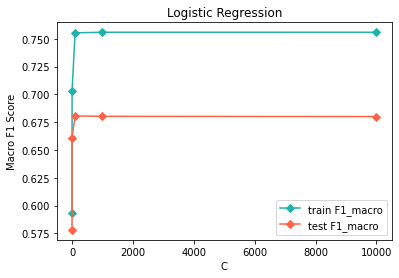

In [ ]:
def plot_cv_trend(cvDf, clfName):
    plt.figure(figsize=(6,4))
    
    x = [list(p.values())[0] for p in cvDf['params'].values]
    param = list(cvDf['params'].values[0].keys())[0]
    
    test = cvDf['mean_test_score'].values
    train = cvDf['mean_train_score'].values
    plt.plot(x, train, color=colour1, marker='D', label='train F1_macro')
    plt.plot(x, test, color=colour2, marker='D', label='test F1_macro')
    plt.title(clfName)
    plt.xlabel(param)
    plt.ylabel('Macro F1 Score')
    plt.legend()
    
    return None

def compute_95_CI(cvDf):
    """
    Computes a 95% confidence interval for the test scores.
    """
    n = cvDf.shape[0]
    m = 4
    intervals = []
    
    for i in range(n):
        mean = cvDf.iloc[i, 11]
        sem = cvDf.iloc[i, 12] / np.sqrt(n)
        test_ci_low, test_ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=sem)
        intervals.append((round(test_ci_low, 4), round(test_ci_high, 4)))
        
    cvDf = cvDf.copy()
    cvDf['95% CI'] = intervals
    cvDf = cvDf[['params', 'mean_test_score', '95% CI']]
    cvDf['mean_test_score'] = cvDf['mean_test_score'].round(4)
    
    return cvDf
        

plot_cv_trend(lr_cvDf, clfName='Logistic Regression')
compute_95_CI(lr_cvDf)

The plot above shows the train and test score when varying the regularization hyperparameter C for the logistic regression classifier.  The regularization strength is increased as C decreases.  Increasing the regularization should increase the test scores up to a certain point and decrease the train score monotonically.  We can see at very low regularization (high C), the test score is already maximized and further increasing regularization only decreases the performance.  This feature set is insensitive towards regularization and seems to work the best with little regularization.  Since the number of values is only 5, 95% confidence intervals can be constructed using the t distribution.  The confidence intervals are overlapping for models with C from 1 to 10000 so we can only conclude that one of these classifiers is the best performing one.

In [ ]:
# Cross validation hyperparameter tuning for random forests
rf_parameters = {'max_depth':(20,50,100,200,500)}

rf_clf_cv = RandomForestClassifier(n_estimators=100, random_state=1513)
rf_gs_clf = GridSearchCV(rf_clf_cv, 
                      rf_parameters, 
                      cv=5, 
                      scoring='f1_macro', 
                      return_train_score=True,
                      verbose=1)

#rf_gs_clf.fit(X_cv5, y_cv)

In [ ]:
#rf_cvDf = pd.DataFrame(rf_gs_clf.cv_results_)
rf_cvDf = pd.DataFrame(
  {'mean_fit_time': {0: 27.8209979057312,
  1: 56.52543416023254,
  2: 87.50259208679199,
  3: 122.78625407218934,
  4: 122.55706357955933},
 'std_fit_time': {0: 0.46256479093829034,
  1: 0.16987569829052712,
  2: 0.5662363742240634,
  3: 4.704969390040319,
  4: 10.39567015892591},
 'mean_score_time': {0: 0.3037869930267334,
  1: 0.4771242141723633,
  2: 0.7001270771026611,
  3: 0.9656539916992187,
  4: 0.8862359523773193},
 'std_score_time': {0: 0.014028684892912237,
  1: 0.02908817137512047,
  2: 0.017006634544777036,
  3: 0.04435195876256116,
  4: 0.15489648464037797},
 'param_max_depth': {0: 20, 1: 50, 2: 100, 3: 200, 4: 500},
 'params': {0: {'max_depth': 20},
  1: {'max_depth': 50},
  2: {'max_depth': 100},
  3: {'max_depth': 200},
  4: {'max_depth': 500}},
 'split0_test_score': {0: 0.6435773298334462,
  1: 0.7422553698845124,
  2: 0.7703807700700589,
  3: 0.7685965155224583,
  4: 0.7667870868841503},
 'split1_test_score': {0: 0.674151892351911,
  1: 0.7594242776844298,
  2: 0.7761389374276216,
  3: 0.7672471358826725,
  4: 0.7667507717907291},
 'split2_test_score': {0: 0.6177528760244078,
  1: 0.7558780973697927,
  2: 0.7753861498669401,
  3: 0.7791155812206443,
  4: 0.7755100750247128},
 'split3_test_score': {0: 0.6257302668185004,
  1: 0.7492510943313635,
  2: 0.7704113512390749,
  3: 0.7720508287204029,
  4: 0.7681247479492015},
 'split4_test_score': {0: 0.5788070171176264,
  1: 0.7481653952648585,
  2: 0.7732374280134677,
  3: 0.7703588372477933,
  4: 0.7699107864419479},
 'mean_test_score': {0: 0.6280038764291783,
  1: 0.7509948469069914,
  2: 0.7731109273234326,
  3: 0.7714737797187943,
  4: 0.7694166936181484},
 'std_test_score': {0: 0.031313751294345736,
  1: 0.00603864830207376,
  2: 0.0024125900978624664,
  3: 0.0041500934888390045,
  4: 0.0032577452037046775},
 'rank_test_score': {0: 5, 1: 4, 2: 1, 3: 2, 4: 3},
 'split0_train_score': {0: 0.6733316718368699,
  1: 0.8167491273443017,
  2: 0.9125343941181404,
  3: 0.9777543643527834,
  4: 0.9976362013679982},
 'split1_train_score': {0: 0.681144360465123,
  1: 0.8216407016300862,
  2: 0.9110558800196812,
  3: 0.9802984766386735,
  4: 0.9975033402849864},
 'split2_train_score': {0: 0.643436511226511,
  1: 0.8190483190215364,
  2: 0.9111616214016529,
  3: 0.978832183651196,
  4: 0.9977635920683099},
 'split3_train_score': {0: 0.6612810316532692,
  1: 0.8213630689759955,
  2: 0.9168449390041574,
  3: 0.9812115241232744,
  4: 0.9977222725893188},
 'split4_train_score': {0: 0.6178421467104933,
  1: 0.8167322654325381,
  2: 0.9150088223015567,
  3: 0.9810879216459747,
  4: 0.9979125056067815},
 'mean_train_score': {0: 0.6554071443784533,
  1: 0.8191066964808915,
  2: 0.9133211313690378,
  3: 0.9798368940823803,
  4: 0.997707582383479},
 'std_train_score': {0: 0.02268312428246571,
  1: 0.002131284209004203,
  2: 0.002266244620952468,
  3: 0.001342692019463971,
  4: 0.00013576192290834057}}
)
rf_cvDf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,27.820998,0.462565,0.303787,0.014029,20,{'max_depth': 20},0.643577,0.674152,0.617753,0.625730,0.578807,0.628004,0.031314,5,0.673332,0.681144,0.643437,0.661281,0.617842,0.655407,0.022683
1,56.525434,0.169876,0.477124,0.029088,50,{'max_depth': 50},0.742255,0.759424,0.755878,0.749251,0.748165,0.750995,0.006039,4,0.816749,0.821641,0.819048,0.821363,0.816732,0.819107,0.002131
2,87.502592,0.566236,0.700127,0.017007,100,{'max_depth': 100},0.770381,0.776139,0.775386,0.770411,0.773237,0.773111,0.002413,1,0.912534,0.911056,0.911162,0.916845,0.915009,0.913321,0.002266
3,122.786254,4.704969,0.965654,0.044352,200,{'max_depth': 200},0.768597,0.767247,0.779116,0.772051,0.770359,0.771474,0.004150,2,0.977754,0.980298,0.978832,0.981212,0.981088,0.979837,0.001343
4,122.557064,10.395670,0.886236,0.154896,500,{'max_depth': 500},0.766787,0.766751,0.775510,0.768125,0.769911,0.769417,0.003258,3,0.997636,0.997503,0.997764,0.997722,0.997913,0.997708,0.000136


,params,mean_test_score,95% CI
0,{'max_depth': 20},0.6280,"(0.5891, 0.6669)"
1,{'max_depth': 50},0.7510,"(0.7435, 0.7585)"
2,{'max_depth': 100},0.7731,"(0.7701, 0.7761)"
3,{'max_depth': 200},0.7715,"(0.7663, 0.7766)"
4,{'max_depth': 500},0.7694,"(0.7654, 0.7735)"


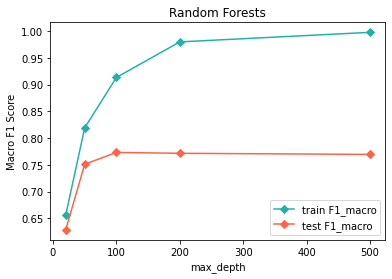

In [ ]:
plot_cv_trend(rf_cvDf, clfName='Random Forests')
compute_95_CI(rf_cvDf)

The plot above shows the train and test performance as the max_depth hyperparameter is varied for the random forests classifier.  We can see that the test performance is poor with small depth, maximizes at a depth of 100 and begins to decrease at greater depths.  The train score monotonically increases as the depth is increased, signifying that the model is overfitting to the data.  Therefore, the best depth is around a depth of 100.  Looking at the 95% confidence intervals, they are overlapping for depths of 100, 200, and 500 so we can conclude one of these is the best depth to use.

Since the 95% CI for the random forest classifier is well above the one for the logistic regression, we can conclude that the random forest classifier performs better.  We will use the random forest classifier with a max depth of 100 as the final classifier to use of the test set.

### Model Testing

Finally, we will test our final model using the untouched test set.

In [ ]:
# Fit train data to best model
production_clf = RandomForestClassifier(n_estimators=100, random_state=1513, max_depth=100) 
production_clf.fit(X_cv5, y_cv)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1513,
                       verbose=0, warm_start=False)

In [ ]:
X_test1, featNames =  test_transform_pipeline(X_test, *pipelineArgs5, returnFeatures=True)  # Transform test set
y_test_pred = production_clf.predict(X_test1)  # Make predictions on test set

The classification report below shows how well the model performs.  The macro F1 score is 78%, which is quite good.  The model performs the best with classifying r/funny, with a 99% recall and 83% precision.  This is likely because 60% of all samples are in this class.  The model performs poorly with the recall of r/WTF and r/pics with only 58% and 57% respectively.   The model performs the worst at classifying r/pics with a f1 score of only 67%.  Surprisingly, the model classifies r/movies quite well, with a F1 score of 86%, even though it consisted of only 8% of all the samples.  This could be because the the words in r/movies have higher PMI scores than the words in other classes.

In [ ]:
testReport = classification_report(y_test, y_test_pred)
print(testReport)

              precision    recall  f1-score   support

         WTF       0.82      0.58      0.68       739
       funny       0.83      0.99      0.90      3027
      movies       0.97      0.78      0.86       404
        pics       0.83      0.57      0.67       838

    accuracy                           0.84      5008
   macro avg       0.86      0.73      0.78      5008
weighted avg       0.84      0.84      0.83      5008



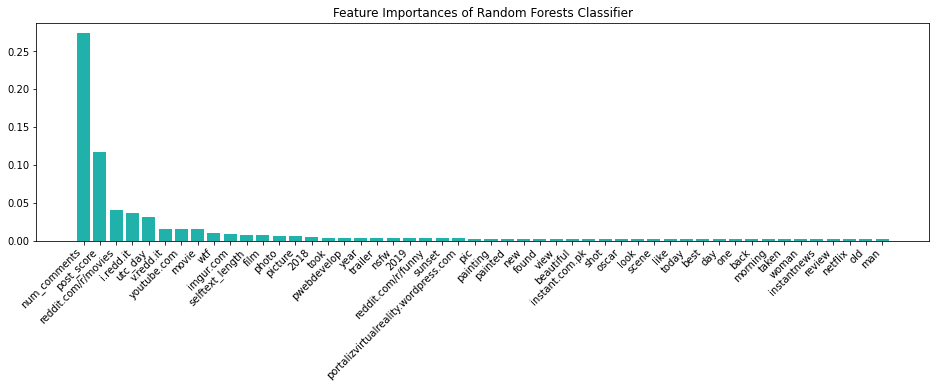

In [ ]:
def plot_feature_importance(clf, featureNames, limit=25):
    importances = clf.feature_importances_  # Get feature importances
    sortedArgs = np.argsort(importances)[::-1]  # Sorted indices
    sortedImportances = importances[sortedArgs]  # Sort importances
    sortedFeatureNames = featureNames[sortedArgs]  # Sort feature names
    
    plt.figure(figsize = (16,4))
    plt.bar(sortedFeatureNames[0:limit], sortedImportances[0:limit], color=colour1)
    plt.title('Feature Importances of Random Forests Classifier')
    plt.xticks(rotation=45, ha='right')
    
    return None

plot_feature_importance(production_clf, featNames, limit=50)

The bar graph above shows the top 25 most important feautres in the random forest classifier.  The most important feature is num_comments.  As we saw in the box plots, this is an informative feature for distinguishing r/funny from other classes.  The post_score as we saw in the box plots is informative for distinguishing r/funny and r/pics from the other two classes.  Suprisingly, the post day is also highly informative provided the trends were not extremely obvious from the bar plots.  The two most common websites are also highly informative as expected from the high PMI scores.  We can also see that many of the words with high PMI are informative such as "movie", "film", "photo".

The confusion matrix below shows where the misclassifications are happening.  We can see many r/WTF posts are misclassified as r/funny and many r/pics posts are misclassified as r/funny.  This behaviour is expected since the majority of samples are in r/funny and the classifier may not have enough samples to learn the differences between r/WTF, r/pics, and r/funny.  From the website PMI analysis, we also saw that r/WTF and r/funny share a positive PMI for v.redd.it, which is the 6th most important feature.  Also, r/pics and r/funny share a positive PMI for i.redd.it, the fourth most important feature.  These reasons may be the source of confusion.

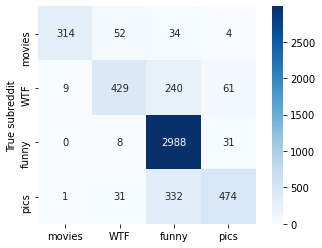

In [ ]:
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=my_subreddits)
    
    cmDf = pd.DataFrame(cm, index=my_subreddits, columns=my_subreddits)
    cmDf.index.name='True subreddit'
    plt.figure(figsize=(6,4))
    
    sns.heatmap(cmDf, annot=True, cmap='Blues', fmt='g', square='True')

plot_cm(y_test, y_test_pred)

## Part 4: Sentiment Analysis

### (a)  Using NLTK Vader to compute sentiment scores of the title.

The below function computes the vader sentiment for each post and adds the score in the vader column.

In [ ]:
def get_vader(dataDf, column):
    """
    Returns dataframe with title, subreddit, and vader score column.
    """
    df = dataDf.copy()
    
    sid = SentimentIntensityAnalyzer()

    def compute_vader(text):
        vader = sid.polarity_scores(text)['compound']
        return vader
    
    df['vader'] = df[column].apply(compute_vader)
    df = df[['title', 'vader', 'subreddit']]
    
    return df

vaderDf = get_vader(data, 'title')
vaderDf.head()

,title,vader,subreddit
1,"In 1964, an average wage worker had to clock 8...",0.4404,pics
5,Here’s a reminder to grab one of these for a b...,0.0000,pics
13,My best photo of 2018!,0.6696,pics
14,Have a happy 2019 you sexy people!,0.8122,pics
15,I’ve seen several movies/shows over the past f...,0.1431,movies


### (b)  Analysis of the distribution of Vader sentiments.

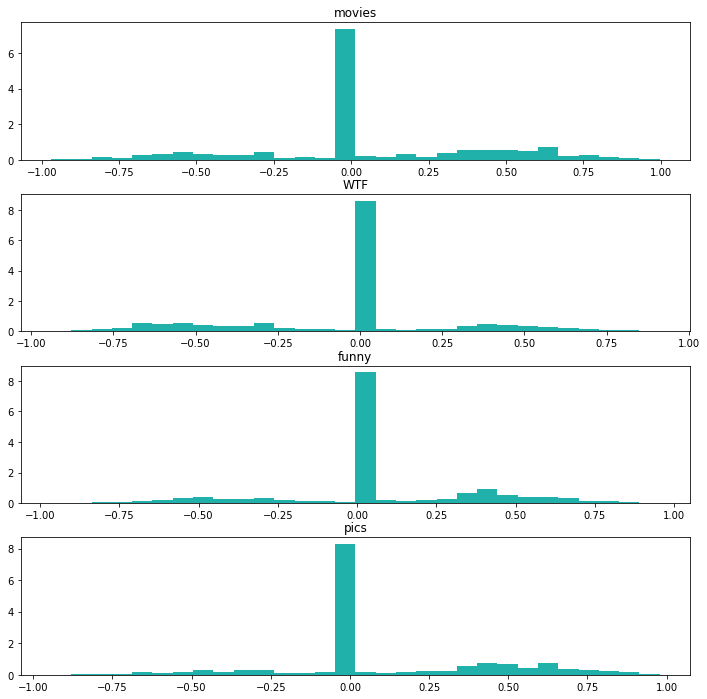

In [ ]:
def plot_vader_distribution(vaderDf, removeZero=False):
    fig, axes = plt.subplots(4, 1, figsize=(12,12))
    plt.subplots_adjust(hspace=0.25)
    
    for i, sr in enumerate(my_subreddits):
        if removeZero == True:
            heights = vaderDf[(vaderDf['subreddit'] == sr) & (vaderDf['vader'] != 0)]['vader'].values
        else:
            heights = vaderDf[vaderDf['subreddit'] == sr]['vader'].values
        
        y, x, patches = axes[i].hist(heights, bins=30, density=True, color=colour1)
        axes[i].set(title=sr)

    return None

plot_vader_distribution(vaderDf)

The histograms above show the distribution of vader scores for each subreddit.  For all of the subreddits, most of the vader scores are 0 (neutral).  We will remove posts with 0 vader and replot to better understand the distribution.

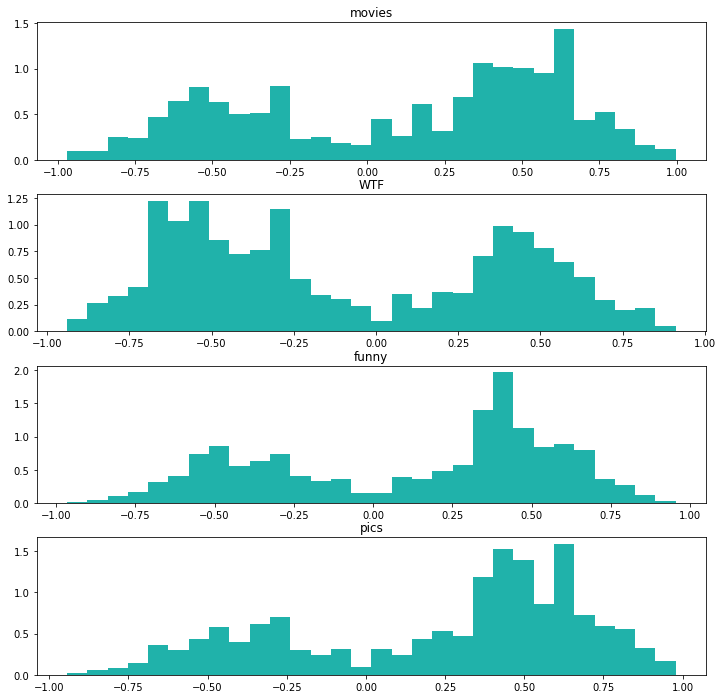

In [ ]:
plot_vader_distribution(vaderDf, removeZero=True)

Removing the neutral sentiments reveal a bimodal distribution with modes that likely represent the negative and positive sentiment vader scores.  We can see that r/movies, r/funny, and r/pics has more posts with positive sentiment whereas r/WTF has more posts with negative sentiment.

### (c)  Defining a sentiment threshold to classify titles as positive or negative.

To define thresholds for posts that are clearly positive or negative according to the vader score, we can fit a bimodal Gaussian distribution to the data and compute the quartiles for the two gaussian distributions.  We'll take the Q3 of the negative sentiment Gaussian and Q1 of the positive sentiment Gaussian as the thresholds.

Q3=-0.28, Q1=0.34


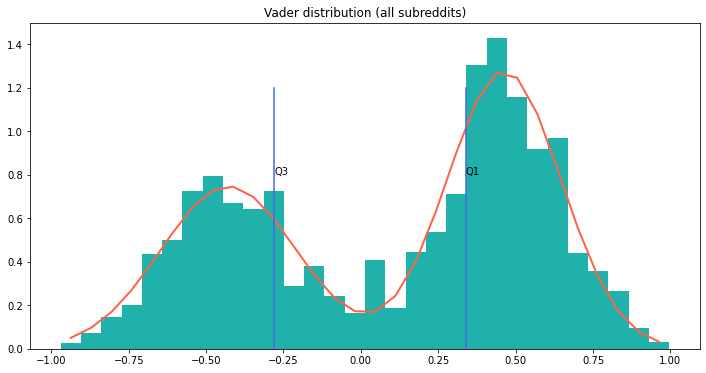

In [ ]:
def fit_bimodal(vaderDf):
    # Referenced this post for fitting bimodal distributions
    # https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python/35992526
    def bimodal(x, mu1, sigma1, mu2, sigma2, p):
        F1 = (1 / (sigma1*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu1)/sigma1)**2)
        F2 = (1 / (sigma2*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mu2)/sigma2)**2)
        
        return p * F1 + (1-p) * F2
    
    plt.figure(figsize=(12,6))
    
    heights = vaderDf[vaderDf['vader'] != 0]['vader'].values  # Remove 0 sentiment posts
    y, x, patches = plt.hist(heights, bins=30, density=True, color=colour1)  # Plot histogram
    x_centered = (x[1:] + x[:-1]) / 2  # Take middle of bin
    
    popt, pcov = curve_fit(bimodal, x_centered, y, p0=[-0.5, 0.25, 0.5 ,0.25, 0.5])  # Fit bimodal distribution
    plt.plot(x_centered, bimodal(x_centered, *popt), color=colour2, linewidth=2)  # Plot bimodal distribution
            
    Q3 = popt[0] + 0.6745 * popt[1]  # Q3 of left gaussian
    Q1 = popt[2] - 0.6745 * popt[3]  # Q1 of right gaussian
    
    # Plot lines to show Q1, Q3
    Q3Line = plt.axvline(x=Q3, ymax=0.8, color=colour3)
    Q1Line = plt.axvline(x=Q1, ymax=0.8, color=colour3)
    
    plt.text(Q3Line.get_data()[0][0], Q3Line.get_data()[1][1], 'Q3')
    plt.text(Q1Line.get_data()[0][0], Q3Line.get_data()[1][1], 'Q1')
    
    print('Q3={}, Q1={}'.format(round(Q3,2), round(Q1,2)))
    
    plt.title("Vader distribution (all subreddits)")

    return Q3, Q1

negThresh, posThresh = fit_bimodal(vaderDf)

The below function will use the vader thresholds to classify the posts as postive, neutral, or negative and record it in the sentiment column.

In [ ]:
def get_sentiment(vaderDf, negThresh, posThresh):
    """
    Returns dataframe with added sentiment column based on vader score and provided thresholds.
    """
    df = vaderDf.copy()
    
    def classify_sentiment(score):
        if score < negThresh:
            return "negative"
        elif score > posThresh:
            return "positive"
        else:
            return "neutral"
        
    df['sentiment'] = df['vader'].apply(classify_sentiment)
    
    return df

sentimentDf = get_sentiment(vaderDf, negThresh, posThresh)
sentimentDf.head()

,title,vader,subreddit,sentiment
1,"In 1964, an average wage worker had to clock 8...",0.4404,pics,positive
5,Here’s a reminder to grab one of these for a b...,0.0000,pics,neutral
13,My best photo of 2018!,0.6696,pics,positive
14,Have a happy 2019 you sexy people!,0.8122,pics,positive
15,I’ve seen several movies/shows over the past f...,0.1431,movies,neutral


### (d)  Analysis of top words with positive and negative titles for each subreddit.

In [ ]:
def sentiment_pmi(sentimentDfCleaned, column, k):
    """
    Returns dataframe of top words ranked by pmi score between word and sentiment classes, computed separately for 
    each subreddit.
    """
    
    columnNames = []
    for sr in my_subreddits:
        columnNames.append(sr + ' positive')
        columnNames.append(sr + ' negative')
    
    
    allDataDf = pd.DataFrame(columns=columnNames, index=np.arange(k))
    
    for srIDX, sr in enumerate(my_subreddits):
        dataDf = sentimentDfCleaned[(sentimentDfCleaned['sentiment'] != 'neutral') & (sentimentDfCleaned['subreddit'] == sr)].copy()  # Remove neutral posts
        allWords = [word for word in np.hstack(dataDf[column].str.split().values) if word != ""]  # All words, remove empty strings
        topk = Counter(allWords).most_common(k)  # Counter for top k frequent words
        topkWords = [word for word, freq in topk]  # List of top k words

        topkDf = dataDf[dataDf[column].str.split(expand=True).isin(topkWords).any(axis=1)]  # Dataframe containing posts with top k words
        n = len(allWords)  # Total number of words

        sentiments = ['positive', 'negative']
        wordSent = {}  # Nested dictionary of word counts for each sentiment
        sentTotals = {}  # Dictionary of total words for each sentiment
        pmidata = {}  # Dictionary to store pmi data

        for s in sentiments:
            sentDf = topkDf[topkDf['sentiment'] == s]

            sentWords = np.hstack(sentDf[column].str.split().values)  # All words in sentiment

            sentTotals[s] = len(sentWords)  # Number of words in sentiment
            wordSent[s] = dict(Counter(sentWords).most_common())  # Dict of word counts in sentiment
            pmidata[s] = []

        for word, freq in topk:

            for s in sentiments:
                try:
                    pxy = wordSent[s][word] / sentTotals[s]
                except:  # site does not exist in sentiment
                    pxy = 0

                px = freq / n

                if pxy == 0:  # Prevent log(0)
                    pmi = np.nan
                else:
                    pmi = np.log2(pxy / px)

                pmidata[s].append(pmi)

        pmiDf = pd.DataFrame(pmidata, index=topkWords)

        sortedData = {}

        for s in sentiments:
            sortedPmi = pmiDf.sort_values(by=s, ascending=False)[s].values  # Sort by pmi 
            sortedWords = pmiDf.sort_values(by=s, ascending=False)[s].index  # Index (word) from sorted pmi
            sortedCombined = [s + ' (' + str(round(p,2)) + ')' for p, s in zip(sortedPmi, sortedWords)]  # Combine
            sortedData[s] = sortedCombined

        allDataDf.iloc[:, srIDX*2 : srIDX*2+2] = pd.DataFrame(sortedData).values

    return allDataDf

sentimentDfCleaned = sentimentDf.copy()
sentimentDfCleaned['title_cleaned'] = dataText['title_cleaned']

sentiment_pmi(sentimentDfCleaned, column='title_cleaned', k=50).head(10)

,movies positive,movies negative,WTF positive,WTF negative,funny positive,funny negative,pics positive,pics negative
0,free (0.88),war (1.69),love (1.8),fuck (1.14),true (1.06),fuck (2.17),love (0.68),cat (1.08)
1,award (0.88),bad (1.64),good (1.75),wrong (1.14),best (1.05),poor (2.14),best (0.66),dog (0.93)
2,favorite (0.88),horror (1.62),best (1.74),dead (1.1),love (1.04),damn (2.12),amazing (0.64),last (0.84)
3,good (0.88),star (1.2),friend (1.71),kill (1.08),great (1.01),shit (2.08),beautiful (0.64),ago (0.82)
4,best (0.87),trailer (0.96),like (1.58),stop (1.07),nice (1.0),wrong (1.92),great (0.62),old (0.75)
5,help (0.85),review (0.82),party (1.54),death (1.07),lol (1.0),say (1.23),2018 (0.62),work (0.69)
6,win (0.83),know (0.81),look (1.41),weird (1.07),like (0.98),got (1.08),happy (0.62),one (0.61)
7,love (0.82),first (0.79),hand (1.36),shit (1.03),friend (0.97),dog (1.06),favorite (0.61),little (0.56)
8,online (0.82),new (0.66),$ (1.02),wtf (1.03),better (0.97),cat (1.05),like (0.61),today (0.51)
9,great (0.82),amp (0.64),one (0.98),back (0.97),good (0.96),people (1.02),friend (0.6),time (0.48)


The dataframe above shows the top 10 ranked words by PMI for positive and negative sentiments, for each subreddit.  PMI is once again used because it tells us which words are most informative for distinguishing each sentiment class.  It's appropriate here because if we used word frequency instead, we may get generic words that are frequent in both sentiment classes.  

As expected, we can see general positive words across all subreddits such as "good", "best", "love" as well as general negative words.  There are also some interesting subreddit specific words.  In r/pics and r/funny, "cat" and "dog" is in the negative words, indicating negative sentiment towards these words.  In r/WTF, the negative words are mostly profanity.  In r/movies we can see film related words in the negative words such as "star", "trailer", "review.